In [155]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch.optim as optim
import logging

import torch
import torch.nn.functional as F
import torch.nn as nn
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

import gc
%matplotlib inline

In [156]:
df = pd.read_csv('/Volumes/Seagate/kaggle/facial-keypoints-detection/test.csv')

In [157]:
df_images = df['Image'].map(lambda x : list(map(int,x.split(' '))))

In [158]:
df_images = df_images.map(lambda x: list((np.array(x) - np.array(x).mean())/ np.array(x).std()))

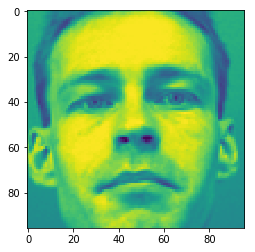

In [159]:
plt.imshow(np.array(df_images.iloc[40]).reshape((96,96)))
plt.show()

In [160]:
class c_unit(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size):
        super(c_unit, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size)
        self.conv1_bn = nn.BatchNorm2d(out_channels)
        
    def forward(self, x, with_max_pool = True):
        x = self.conv1(x)
        x = self.conv1_bn(x)
        x = F.relu(x)
        if with_max_pool:
            x = F.max_pool2d(x, kernel_size=2)
        return x
    
class r_unit(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(r_unit, self).__init__()
        self.fc1 = nn.Linear(in_dim, out_dim)
        self.bm = nn.BatchNorm1d(out_dim)
        
    def forward(self, x, with_batch_norm = False):
        x = self.fc1(x)
        if with_batch_norm:
            x = self.bm(x)
        x = F.relu(x)
        return x

class cnn_mod(nn.Module):
    def __init__(self):
        super(cnn_mod, self).__init__()
        self.c_unit_1 = c_unit(1,12,2)
        self.c_unit_2 = c_unit(12,64,2)
        self.c_unit_3 = c_unit(64,128,2)
        self.c_unit_4 = c_unit(128,256,2)
        self.c_unit_5 = c_unit(256,512,2)
        
        self.r_unit_1 = r_unit(512*2*2, 1024)
        self.r_unit_2 = r_unit(1024,256)
        self.r_unit_3 = r_unit(256,30)
        self.dp1 = nn.Dropout(p=0.4)
    
    def forward(self, x, verbose=False):
        x = self.c_unit_1(x)
        x = self.dp1(x)
    
        x = self.c_unit_2(x)
        x = self.dp1(x)
        
        x = self.c_unit_3(x)
        x = self.dp1(x)
        
        x = self.c_unit_4(x)
        x = self.dp1(x)
        
        x = self.c_unit_5(x)
        x = self.dp1(x)

        x = x.view(-1, 512*2*2)
        
        # now use FC layer with relu
        x = self.r_unit_1(x, True)
        x = self.dp1(x)
        
        x = self.r_unit_2(x, True)
        x = self.dp1(x)
        
        x = self.r_unit_3(x)
        x = F.relu(x)
        return x

In [161]:
model = cnn_mod().eval()
model.load_state_dict(torch.load('cnn_mod.pth',map_location=lambda storage, loc: storage))

<All keys matched successfully>

In [162]:
X = np.array(df_images.values)
X = np.array([np.array(x) for x in X])
X = torch.tensor(X).float().view(-1,1,96,96)

In [163]:
result = []
for i in range(0,X.shape[0],50):
    print('\r', 'Iteration', i,end='')
    result.append(model(X[i:i+50]).flatten().detach().numpy())
#model(X[:50]).flatten()

 Iteration 1750

In [164]:
result = np.concatenate(result).flatten()

In [165]:
result.shape

(53490,)

In [166]:
result = result.reshape((1783,30))

In [167]:
df_output = pd.read_csv('/Volumes/Seagate/kaggle/facial-keypoints-detection/IdLookupTable.csv')

In [168]:
labels = df_output.iloc[:30].FeatureName.values

In [169]:
mapper = {}
inv_mapper = {}
for i in range(0,len(labels)):
    mapper[i] = labels[i]
    inv_mapper[labels[i]] = i

In [170]:
df_output['vector_output'] = df_output.FeatureName.map(lambda x : inv_mapper[x])

In [171]:
for i in range(1,1784):
    indices = df_output[df_output['ImageId'] == i].vector_output.values
    df_output.loc[df_output['ImageId'] == i, 'Location'] = result[i-1][indices]

In [175]:
df_output[['RowId','Location']].set_index('RowId').to_csv('result.csv')